In [365]:
import numpy as np
import matplotlib.pyplot as plt

In [366]:
def runge_kutta(function, y0: np.ndarray | float, time_space: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    h = time_space[1] - time_space[0]
    num = len(time_space)
    x_a = time_space

    y_a = [y0] * (num)

    for i in range(num - 1):
        k0 = function(x_a[i], y_a[i])
        k1 = function(x_a[i] + h / 2, y_a[i] + h * k0 / 2)
        k2 = function(x_a[i] + h / 2, y_a[i] + h * k1 / 2)
        k3 = function(x_a[i] + h, y_a[i] + h * k2)
        y_a[i + 1] = y_a[i] + h / 6 * (k0 + 2 * k1 + 2 * k2 + k3)

    return x_a, np.array(y_a)

In [394]:
n = 5 # 0 - 3
q = 4
print(f"{q=}")

Q = 200
alpha = np.array([20, 16, 12, 8, 4]) # n
k = np.append([0], [0.3, 0.2, 0.1, 0.1]) # n-1, 0<=k_i<=1
m = np.append([0], [4, 3, 0.1, 0.1]) # n-1
# a = np.append([0], [0.8, 0.2, 0.1]) # n-1, 0<=a_i<=1
a = np.append([0], [0.8, 0, 0, 0])

g = np.append([0], k[1:] * alpha[:-1] / alpha[1:])
H = np.append([1], [ np.prod(g[2-(i%2):i+2:2]) for i in range(1, n) ])

mu =np.append([0], m[1:] / alpha[1:])
f = np.append([0], [ sum(mu[2-(i%2):i+2:2]/H[2-(i%2):i+2:2]) for i in range(1, n) ])

print( alpha, k, m )

q=4
[20 16 12  8  4] [0.  0.3 0.2 0.1 0.1] [0.  4.  3.  0.1 0.1]


In [395]:
# Flow

N = np.zeros(n)

if q % 2 == 0:
    N[0] = Q / ( alpha[0] * f[q] )
    N[1] = f[q]
else:
    N[0] = f[q]
    N[1] = Q / ( alpha[0] * f[q] )


for s in range(1, n//2):
    N[s*2] = H[2*s-1] * (N[0] - f[2*s-1])
    N[s*2+1] = H[2*s] * (N[1] - f[2*s])

NF = N.copy()
NF = np.where(NF < 0, 0, NF)

print( alpha[0] * f[:-1] * f[1:] )
print(NF)

[ 0.         12.5        16.66666667 25.        ]
[7.11111111 1.40625    2.41666667 0.125      0.        ]


In [396]:
# flow chain
def get_right_flow(func_v, func_1=None):
    func_1 = func_1 or func_v
    def right_flow(t, x):
        return np.append(
            [Q - alpha[0] * func_1(x[0]) * x[1]],
            [
                -m[i] * x[i] + k[i] * alpha[i-1] * func_v(x[i-1]) * x[i] - (x[i+1] if i < n-1 else 0 ) * alpha[i] * func_v(x[i])
                for i in range(1, n)
            ]
        )
    return right_flow

def identity(x):
    return x

# def right_flow(t, x):
#     return np.append(
#         [Q - alpha[0] * x[0] * x[1]],
#         [
#             x[i] * (-m[i] + k[i] * alpha[i-1] * x[i-1] - (alpha[i] * x[i+1] if i < n-1 else 0 ))
#             for i in range(1, n)
#         ]
#     )

In [397]:
t_s = np.arange(0, 1000, 0.01)
N0 = np.array([ 2 ] * n)

right_flow = get_right_flow(identity)
# right_flow = get_right_flow(np.atan)

Tl, Nl = runge_kutta(right_flow, N0, t_s)

[7.11111111 1.40625    2.41666667 0.125      0.        ]
[7.11111111 1.40625    2.41666667 0.125      0.35      ]


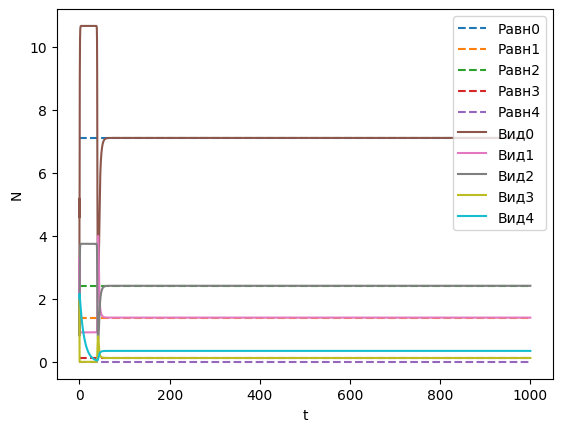

In [398]:
slc_start = 0
slc = -1

start = 0
leg = []

for i in range(start,n):
    plt.plot([0, Tl[slc-1]], [NF[i]]*2, "--")
    leg.append(f"Равн{i}")

for i in range(start,n):
    plt.plot(Tl[slc_start:slc], Nl[slc_start:slc,i])
    leg.append(f"Вид{i}")

plt.legend(
    leg, 
    loc='upper right'
)
plt.xlabel('t')
plt.ylabel('N')
print(NF)

print(Nl[-1])

plt.savefig("./figs/exp1.pdf")

In [362]:
Q = 100

# Cycle
_phi = a[2::2] * m[2::2] * H[1::2]
phi = np.append([0], np.cumsum(_phi) )

_psi = a[1::2] * m[1::2] * H[::2]
psi = np.append([0], np.cumsum(_psi) )

_sigma = a[1:] * m[1:] * f[:-1] * H[:-1]
sigma = np.append([0], np.cumsum(_sigma) )
#

# Bounds
Q_flow = alpha[0] * f[:-1] * f[1:]
Q_c = np.zeros_like(Q_flow)
for i in range(q):
    s = i // 2
    if i % 2 == 0:
        Q_c[i] -= f[2*s-1] * phi[s] + f[2*s] * psi[s] - sigma[2*s]
    else:
        Q_c[i] -= f[2*s] * psi[s+1] + f[2*s+1] * phi[s] - sigma[2*s+1]
print(Q_c)
Q_c += Q_flow
print(Q_c)

Q_c2 = np.array([0, 
                 m[1] * m[2] * (1 - a[1] * k[1]) / (alpha[1] * k[1] * k[2]),
                 ])
print(Q_c2)
#

#
q = 3

N = np.zeros(n)

if q % 2 == 0:
    N[0] = ( Q + f[q] * psi[q//2] - sigma[q] ) / ( alpha[0] * f[q] - phi[q//2] )
    N[1] = f[q]
else:
    N[0] = f[q]
    N[1] = ( Q + f[q] * phi[q//2] - sigma[q] ) / ( alpha[0] * f[q] - psi[q//2 + 1] )


for s in range(1, n//2):
    N[s*2] = H[2*s-1] * (N[0] - f[2*s-1])
    N[s*2+1] = H[2*s] * (N[1] - f[2*s])


NC = N.copy()
NC = np.where(NC < 0, 0, NC)
#
print(f"{q=} {NC=}")

[0. 0. 0.]
[ 0.         12.5        16.66666667]
[0.  9.5]
q=3 NC=array([0.88888889, 6.8597561 , 0.08333333, 1.57926829])


In [359]:
# cycle chain
def get_right_cycle(func_v, func_1=None):
    func_1 = func_1 or func_v
    def right_cycle(t, x):
        return np.append(
            [ Q - alpha[0] * func_1(x[0]) * x[1] + sum(a * m * x) ],
            [
                -m[i] * x[i] + k[i] * alpha[i-1] * func_v(x[i-1]) * x[i] - (x[i+1] if i < n-1 else 0 ) * alpha[i] * func_v(x[i])
                for i in range(1, n)
            ]
        )
    return right_cycle

In [363]:
t_s2 = np.arange(0, 100, 0.01)
N1 = np.array([ 2 ] * n)

right_cycle = get_right_cycle(identity)
# right_cycle = get_right_cycle(np.atan)

Tl2, Nl2 = runge_kutta(right_cycle, N1, t_s2)

[0.88888889 6.8597561  0.08333333 1.57926829]
[0.88888889 6.8597561  0.08333333 1.57926829]


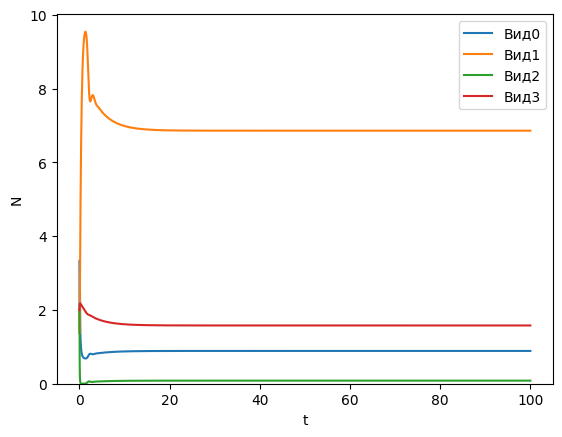

In [364]:
slc = -1

start = 0
leg = []

# for i in range(start,n):
#     plt.plot([0, Tl2[slc-1]], [NC[i]]*2, "--")
#     leg.append(f"Равн{i}")

for i in range(start,n):
    plt.plot(Tl2[:slc], Nl2[:slc,i])
    leg.append(f"Вид{i}")

plt.legend(leg)
plt.ylim(0)
plt.xlabel('t')
plt.ylabel('N')
print(NC)
print( Nl2[-1,:])


# plt.savefig(f"./figs/exp2_Q{Q}.pdf")